<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据准备

```shell
$ tree -L 2 archive 
archive
├── monkey_labels.txt
├── training
│   ├── n0
│   ├── n1
│   ├── n2
│   ├── n3
│   ├── n4
│   ├── n5
│   ├── n6
│   ├── n7
│   ├── n8
│   └── n9
└── validation
    ├── n0
    ├── n1
    ├── n2
    ├── n3
    ├── n4
    ├── n5
    ├── n6
    ├── n7
    ├── n8
    └── n9

22 directories, 1 file
```

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, ConvertImageDtype, Normalize


from pathlib import Path

DATA_DIR1 = Path("/content/training/")
DATA_DIR2 = Path("/content/validation/")

class MonkeyDataset(datasets.ImageFolder):
    def __init__(self, mode, transform=None):
        if mode == "train":
            root = DATA_DIR1 / "training"
        elif mode == "val":
            root = DATA_DIR2 / "validation"
        else:
            raise ValueError("mode should be one of the following: train, val, but got {}".format(mode))
        super().__init__(root, transform)
        self.imgs = self.samples
        self.targets = [s[1] for s in self.samples]

# resnet 要求的，见 https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html
img_h, img_w = 224, 224
transform = Compose([
     Resize((img_h, img_w)),
     ToTensor(),
     Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
     ConvertImageDtype(torch.float),
])


train_ds = MonkeyDataset("train", transform=transform)
val_ds = MonkeyDataset("val", transform=transform)

print("load {} images from training dataset".format(len(train_ds)))
print("load {} images from validation dataset".format(len(val_ds)))

load 1097 images from training dataset
load 272 images from validation dataset


In [3]:
# 数据类别
train_ds.classes, train_ds.class_to_idx

(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
 {'n0': 0,
  'n1': 1,
  'n2': 2,
  'n3': 3,
  'n4': 4,
  'n5': 5,
  'n6': 6,
  'n7': 7,
  'n8': 8,
  'n9': 9})

In [4]:
# 图片路径 及 标签
for fpath, label in train_ds.imgs:
    print(fpath, label)
    break

for img, label in train_ds:
    # c, h, w  label
    print(img.shape, label)
    break

/content/training/training/n0/n0018.jpg 0
torch.Size([3, 224, 224]) 0


In [5]:
# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std

# 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))

In [6]:
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader    

batch_size = 32 #在这里我做了修改，看看效果
# 从数据集到dataloader
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [7]:
for imgs, labels in train_loader:
    print(imgs.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [8]:
## 定义模型

In [9]:
from torchvision.models import resnet50

# 定义一个自定义的 ResNet50 模型类，用于加载预训练的 ResNet50，并根据任务需求定制分类层
class ResNet50(nn.Module):
    # 构造函数中，num_classes 表示目标分类数（默认10类），frozen 参数决定是否冻结预训练模型的所有层（除了最后一层）
    def __init__(self, num_classes=10, frozen=True):
        super().__init__()
        # 加载预训练的 ResNet50 模型，这里使用了 ImageNet1K_V2 的预训练权重
        # weights 参数可以设为 "IMAGENET1K_V2" 使用预训练权重，或设为 None 进行随机初始化
        self.model = resnet50(weights="IMAGENET1K_V2",)

        # 如果 frozen 参数为 True，则冻结所有预训练模型的权重
        if frozen:
            # 遍历模型中所有参数，并将参数的 requires_grad 属性设置为 False
            # 这意味着在训练过程中，这些参数不会被更新，从而减少计算量，并防止预训练特征被破坏
            for param in self.model.parameters():
                param.requires_grad = False  # 冻结权重

        # 以下几行（注释掉的代码）展示了如何部分解冻特定层（例如 layer4 或者 layer4.2.conv3.weight）
        # 这通常用于微调阶段，仅让网络的后部（更高层）的特征进行更新，以适应新任务
        # for param in self.model.layer4.parameters():
        #     param.requires_grad = True  # 解冻 layer4
        # for name, param in self.model.named_parameters():
        #     if name == "layer4.2.conv3.weight":
        #         param.requires_grad = True  # 解冻该层

        # 添加自定义分类层
        # 在预训练的 ResNet50 中，最后一层全连接层（fc）默认输出为 1000 类（对应 ImageNet 的类别数）
        # 打印最后一层的输入通道数，用于确认其维度
        print(self.model.fc.in_features)  # 打印最后一层全连接层输入特征的数目
        # 打印最后一层的输出通道数，通常为 1000
        print(self.model.fc.out_features)  # 打印最后一层全连接层的输出特征数（1000）

        # 将预训练模型的最后一层全连接层替换为一个新的全连接层
        # 新的全连接层的输入特征数与原来保持一致，但输出特征数修改为目标类别数 num_classes
        # 这样就可以将预训练模型用于新的分类任务（例如 10 类分类任务）
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    # 定义前向传播方法，直接调用预训练模型的前向方法完成输入数据的处理和分类预测
    def forward(self, x):
        return self.model(x)

# for idx, (key, value) in enumerate(ResNet50().named_parameters()):
#     print(f"{key:^40}paramerters num: {np.prod(value.shape)}")


In [10]:
model = ResNet50(num_classes=10, frozen=True)
def count_parameters(model): #计算模型总参数量
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 18.4MB/s]

2048
1000


20490

In [11]:
model

ResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [12]:
total_params = sum(p.numel() for p in model.parameters() )
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 23528522


In [13]:
m = nn.AdaptiveAvgPool2d(output_size=(1, 1))
input = torch.randn(1, 2048, 9, 9)
output = m(input)
output.shape

torch.Size([1, 2048, 1, 1])

In [14]:
512*3*3*512

2359296

In [15]:
512*1*1*2048

1048576

In [16]:
512/32

16.0

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [17]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [18]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [19]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [20]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [21]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 20

model = ResNet50(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 sgd
# Optimizers specified in the torch.optim package
# 训练完这个，可以试下其他优化器
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
# tensorboard_callback = TensorBoardCallback("runs/monkeys-resnet50")
# tensorboard_callback.draw_model(model, [1, 3, img_h, img_w])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/monkeys-resnet50", save_step=len(train_loader), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

2048
1000


 45%|████▌     | 315/700 [03:23<04:08,  1.55it/s, epoch=8]

Early stop at epoch 9 / global_step 315


In [22]:
# 画图

import torch
from torchviz import make_dot

# Assuming your model is already defined and named 'model'
# Construct a dummy input
dummy_input = torch.randn(1, 3, 224, 224)  # Replace with your input shape

# Forward pass to generate the computation graph
output = model(dummy_input)

# Visualize the model architecture
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")  # Save the visualization as an image


ModuleNotFoundError: No module named 'torchviz'

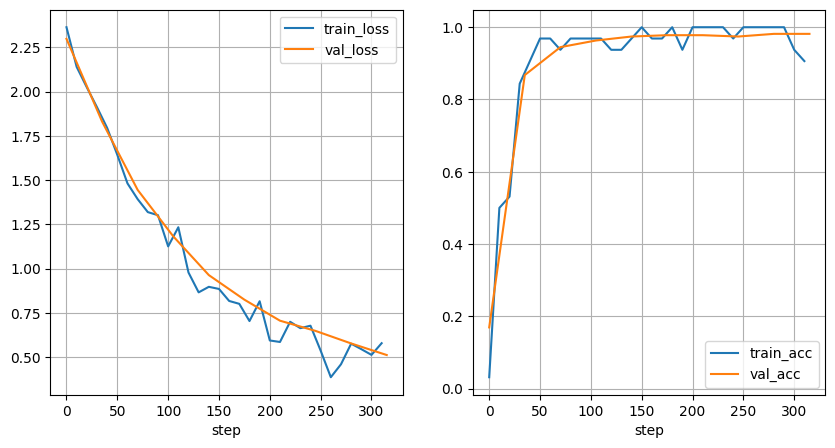

In [23]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [24]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/monkeys-resnet50/best.ckpt",weights_only=True, map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.5120
accuracy: 0.9816
